Fitness - fatigue modelling with Banister
====

This notebook deals with the Banister models \cite{banister1975systems, busso1994} on the evaluation and prediction of athlete performance in function of fatigue and fitness. The general equation is given below:

\begin{equation}
p_{t}=p_{0}+k_{a} \sum_{s=0}^{t-1} e^{-(t-s) / \tau_{a}} w_{s}-k_{f} \sum_{s=0}^{t-1} e^{-(t-s) / \tau_{f}} w_s
\label{eq:banister}
\end{equation}

* $p_{t}$ is the modelled performance at time $t$
* $p_0$ is the initial performance level
* $k_a$ and $k_f$ are fitness and fatigue magnitude factor
* $\tau_a$ and $\tau_f$ are fitness and fatigue time decay
* $w_s$ is the known training load per time unit, or ' the known training load per week (or day) from the first week of training to the week (or day) preceding the performance'

There are however some ***issues with the Banister model*** which are described in detail in \cite{Hellard2006}.
1. The model parameters suffer from poor identifiability, which seems logical as the mechanisms could correct for eachother. This feature leads to a lot of variability in the resulting parameter estimates. The model somehow has been reported to predict reasonably well. The model does have 4 parameters that can bring this in. 
2. On top of that there is usually only limited data, between 10 and 20 data points per athlete, to fit the model.
3. The Banister model parameters might not be so physically accurate, the model plausibility could be low.

There appears to be the upside that the model is stable and parameter estimates do not change much (on top of the other variability?) when a data point is left out.


Things to check on \cite{Hellard2006} still:
1. how was the model prediction assessed?
2. how was bootstrapping used?

# Preparations

## Imports
Python packages needed

In [1]:
#basic
import pandas as pd
import numpy as np
import os, sys
# plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import seaborn as sns
from matplotlib import cm
from palettable.scientific import sequential
# calculations
from scipy.optimize import brute, differential_evolution

## Visualisation settings

In [2]:
# naming of parameters in plots
parname_dict = {
    'k_a' : '$k_a$',
    'k_f' : '$k_f$',
    'tau_a' : r'$\tau_a$',
    'tau_f' : r'$\tau_f$',
    'p_0' : '$p_0$',
}

In [3]:
# overall plot settings
sns.set_style('whitegrid')
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['legend.fontsize'] = 16

# Experimental data

In [4]:
# get all sporter dataset names
dataset_names = [f for f in os.listdir() if 'modellen.xlsx' in f]
dataset_dict = dict() #dictionary to store all data in
for d in dataset_names:
    # read sporter excel file and store in dictionary, referenced by sporter name
    dataset_dict[d[:-14]] = pd.read_excel(d, sheet_name='TSS', index_col=0).loc[:,['Datum', 'TL', 'TT (W)', 'PTE', 'Fitness', 'NTE', 'Fatigue',
       'TT performance', 'Performance', 'Modelfit']] #only store columns of interest

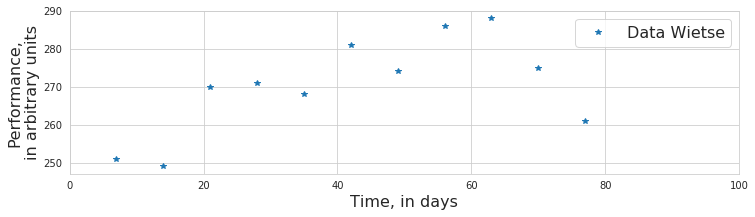

In [5]:
#create figure
fig, ax  = plt.subplots(figsize=(12,3))
#select dataset
sporter = 'Wietse'
data2plot = dataset_dict[sporter]
#plot data
ax.plot(data2plot.loc[:,'TT (W)'],'*', label='Data '+sporter)
#format the figure
ax.set_xlim(0,100);
ax.set_xlabel('Time, in days');
ax.set_ylabel('Performance,\nin arbitrary units');
ax.legend();

# Model

## Banister model

\begin{equation}
p_{t}=p_{0}+k_{a} \sum_{s=0}^{t-1} e^{-(t-s) / \tau_{a}} w_{s}-k_{f} \sum_{s=0}^{t-1} e^{-(t-s) / \tau_{f}} w_s
\label{eq:banister2}
\end{equation}

Below is the implementation for Eq.\ref{eq:banister}. *The same notation is used, thus the meaning of the inputs to the model function* `ff_banister` *can be found under Eq.\ref{eq:banister}*.

### Implementation

In [6]:
def sum_exp(t, k, tau, w_s):
    """calculation for summation exponential term (is this a convolution?)
    needed for the calculation of the fitness and fatigue terms"""
    retval = np.zeros((len(t),1))
    for i in range(1,len(t)-1):
        retval[i] = np.sum(np.exp(-(i-np.arange(i+1))/tau)*w_s[:i+1])
        
    return k*retval

def ff_banister(t, p_0, k_a, k_f, tau_a, tau_f, w_t, tt_W):
    """
    returns the performance at time t calculated with all the input parameters
    """
    p_t = p_0 + sum_exp(t, k_a, tau_a, w_t) - sum_exp(t, k_f, tau_f, w_t)
    
    for ti, tv in enumerate(tt_W):
        if tv>0.1:
            p_t[ti] = p_t[ti] + 2*(k_f-k_a)*w_t[ti-1]
            print(ti)
    
    return p_t

def kobes_way(t, p_0, k_a, k_f, tau_a, tau_f, w_t, tt_W):
    """
    try exactly the  code from the excel file
    """
    retval = np.zeros((len(t),1))
    retval[0] = p_0
    pte = np.zeros((len(t),1))
    nte = np.zeros((len(t),1))
    
    for i in range(1,len(t)):
        pte[i] = (pte[i-1]*np.exp(-1/tau_a) + w_t[i])
        nte[i] = (nte[i-1]*np.exp(-1/tau_f) + w_t[i])
        if tt_W[i]<0.1:
            retval[i] = p_0 + (pte[i])*k_a - (nte[i])*k_f
        else:
            retval[i] = p_0 + (pte[i-1]*np.exp(-1/tau_a))*k_a - (nte[i-1]*np.exp(-1/tau_f))*k_f
            
    simres = np.array((retval, pte, nte)).reshape(3, len(t)).transpose()
        
    return pd.DataFrame(simres, index=t, columns=['overall', 'fit', 'fat'])

### Retrieving data

Select an athlete out of Thibaux, Wietse or Tom

In [7]:
# model inputs
sporter = 'Thibaux'
data4mod = dataset_dict[sporter]
t = data4mod.index.values
data4mod[['TT (W)']] = data4mod[['TT (W)']].fillna(value=0)
data4mod[['TL']] = data4mod[['TL']].fillna(value=0)
w_t = data4mod[['TL']].values.ravel()
tt_w = data4mod[['TT (W)']].values.ravel()

### Verifying model implementation

Checking whether simulated outcomes are the same as those of Kobe V.

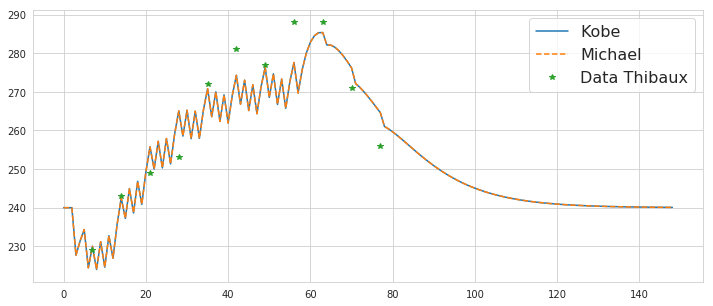

In [8]:
# fit the model using parameters from the excel and compare with Kobe's dank excel code
fig, ax = plt.subplots(figsize=(12,5))
mod_out = kobes_way(t, 240, 0.592627747, 0.830655943, 11.23205693, 6.327383027, w_t, tt_w)
plt.plot(t, data4mod.loc[:,'Modelfit'], label='Kobe')
plt.plot(mod_out['overall'] , '--', label='Michael')
# plt.plot(t, data4mod.loc[:,'TL'], '*', label='TL')
#plot data
ax.plot(t[tt_w>0.1], tt_w[tt_w>0.1],'*', label='Data '+sporter)
plt.legend();


## Optimisation
Visualise the objective function 
Conduct a global optimisation

### Objective function

In [9]:
# objective function
def mod_err_banister(pars, t_loc, w_t_loc, tt_w_loc, err_type='sse', p_0=240):
    """
    pars {list}: contains the parameter values of the Banister model in the following order:
        [k_a, k_f, tau_a, tau_f]
    t_loc {np.array 1D}: time denotation (in days)
    w_t_loc {np.array 1D}: values from TL column in data
    tt_w_loc {np.array 1D}: values from TT (W) column in data
    err_type {string}: specifies model error calculation type, standard sum of squared errors
    """
    # parameter values
    [k_a, k_f, tau_a, tau_f] = pars
    # calculate model output
    mod_out = kobes_way(t_loc, p_0, k_a, k_f, tau_a, tau_f, w_t_loc, tt_w_loc)
    # reformat data for model error calculation
    data2compare = tt_w_loc.copy()
    data2compare[tt_w_loc<0.1] = np.nan
    # model error calculation
    if err_type == 'sse': #sum of squared errors
        mod_err = np.nansum(np.square(mod_out.overall.values - data2compare))
        
    return mod_err

### Actual optimisation

A brute force is carried out, which checks the model fit at a range of specified parameter value combinations.
This is mainly to visualise the objective function.

In [ ]:
par_ranges = (slice(0, 3, 0.1), slice(0, 3, 0.1),
             slice(0, 60, 0.1), slice(0,60,0.1))

par_ranges_dict = {
    'k_a' : np.arange(0,2,step=0.1),
    'k_f' : np.arange(0,2,step=0.1),
    'tau_a' : np.arange(3,20,step=1),
    'tau_f' : np.arange(3,20,step=1),
}
results = brute(mod_err_banister, par_ranges, args=(t, w_t, tt_w), full_output=True, disp=True, workers=32)

### Visualising results

In [ ]:
# how to plot this

fig_brutres = plt.figure(figsize=(10,7), constrained_layout=True)
kleurmap = cm.viridis_r #sequential.Bilbao_10.mpl_colormap

spec = gridspec.GridSpec(ncols=41, nrows=2, figure=fig_brutres)
ax11 = fig_brutres.add_subplot(spec[0, :20])
ax12 = fig_brutres.add_subplot(spec[0, 20:-1])
ax21 = fig_brutres.add_subplot(spec[1, :20])
ax22 = fig_brutres.add_subplot(spec[1, 20:-1])
ax_cb = fig_brutres.add_subplot(spec[:,-1])
# we plot each optimal objective function value for a combination of two selected parameters
# normalising to the same colour scale
normF = plt.Normalize(0, 200)

# plot optimal value found in function of combination of values of two parameters
# right now I have no idea but to rewrite this manually
# bc changing the parameter selection also changes the indexing

# k_a vs k_f
dims = [0,1]
parnames = [list(par_ranges_dict.keys())[i] for i in dims]
disc1 = np.shape(feval)[dims[0]]
disc2 = np.shape(feval)[dims[1]]
# storage of parameter value combinations
p1 = par_ranges_dict[parnames[0]]
p2 = par_ranges_dict[parnames[1]]
P1, P2 = np.meshgrid(p1, p2)
F = P1*2 +P2

#loop over first variable
for i in range(disc1):
    #loop over second variable
    for j in range(disc2):
        F[j,i] = np.sqrt(np.min(feval[i,j,:,:]))

# plot contour
mappab = ax11.contourf(P1, P2, F, norm=normF, cmap=kleurmap)
ax11.set_xlabel(parname_dict[parnames[0]])
ax11.set_ylabel(parname_dict[parnames[1]]);

# tau
dims = [2,3]
parnames = [list(par_ranges_dict.keys())[i] for i in dims]
disc1 = np.shape(feval)[dims[0]]
disc2 = np.shape(feval)[dims[1]]
# storage of parameter value combinations
p1 = par_ranges_dict[parnames[0]]
p2 = par_ranges_dict[parnames[1]]
P1, P2 = np.meshgrid(p1, p2)
F = P1*2 +P2

#loop over first variable
for i in range(disc1):
    #loop over second variable
    for j in range(disc2):
        F[j,i] = np.sqrt(np.min(feval[:,:,i,j]))

# plot contour
ax12.contourf(P1, P2, F, norm=normF, cmap=kleurmap)
ax12.set_xlabel(parname_dict[parnames[0]])
ax12.set_ylabel(parname_dict[parnames[1]]);


# fitness
dims = [0,2]
parnames = [list(par_ranges_dict.keys())[i] for i in dims]
disc1 = np.shape(feval)[dims[0]]
disc2 = np.shape(feval)[dims[1]]
# storage of parameter value combinations
p1 = par_ranges_dict[parnames[0]]
p2 = par_ranges_dict[parnames[1]]
P1, P2 = np.meshgrid(p1, p2)
F = P1*2 +P2

#loop over first variable
for i in range(disc1):
    #loop over second variable
    for j in range(disc2):
#         print(j)
        F[j,i] = np.sqrt(np.min(feval[i,:,j,:]))

# plot contour
ax21.contourf(P1, P2, F, norm=normF, cmap=kleurmap)
ax21.set_xlabel(parname_dict[parnames[0]])
ax21.set_ylabel(parname_dict[parnames[1]]);

# fatigue
dims = [1,3]
parnames = [list(par_ranges_dict.keys())[i] for i in dims]
disc1 = np.shape(feval)[dims[0]]
disc2 = np.shape(feval)[dims[1]]
# storage of parameter value combinations
p1 = par_ranges_dict[parnames[0]]
p2 = par_ranges_dict[parnames[1]]
P1, P2 = np.meshgrid(p1, p2)
F = P1*2 +P2

#loop over first variable
for i in range(disc1):
    #loop over second variable
    for j in range(disc2):
#         print(j)
        F[j,i] = np.sqrt(np.min(feval[:,i,:,j]))

# plot contour
ax22.contourf(P1, P2, F, norm=normF, cmap=kleurmap)
ax22.set_xlabel(parname_dict[parnames[0]])
ax22.set_ylabel(parname_dict[parnames[1]]);


# colorbar
cb = fig_brutres.colorbar(mappab, cax=ax_cb)
cb.set_label('absolute model error', fontsize=16)

# References

(<a id="cit-banister1975systems" href="#call-banister1975systems">Banister, Calvert <em>et al.</em>, 1975</a>) Banister E W, Calvert T W, Savage M V <em>et al.</em>, ``_A systems model of training for athletic performance_'', Aust J Sport Med, vol. 7, number 3, pp. 57--61,  1975.

(<a id="cit-busso1994" href="#call-busso1994">Busso, Candau <em>et al.</em>, 1994</a>) Busso Thierry, Candau Robin and Lacour Jean Ren{\'{e}}, ``_Fatigue and fitness modelled from the effects of training on performance_'', Eur J Appl Physiol Occup Physiol, vol. 69, number 1, pp. 50--54, jan 1994.  [online](https://www.researchgate.net/publication/15242395)

(<a id="cit-Hellard2006" href="#call-Hellard2006">Hellard, Avalos <em>et al.</em>, 2006</a>) Hellard Philippe, Avalos Marta, Lacoste Lucien <em>et al.</em>, ``_Assessing the limitations of the Banister model in monitoring training_'', J Sports Sci, vol. 24, number 5, pp. 509--520,  2006.

